In [1]:
!python -V

Python 3.11.5


# Build model to predict trip duration


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [3]:
# ! wget https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet

In [4]:
# for reading parquet files
df = pd.read_parquet("data/green_tripdata_2021-01.parquet")
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [5]:
df.trip_type.value_counts()

trip_type
1.0    39233
2.0     1238
Name: count, dtype: int64

In [6]:
## Calulatin duration

# df.lpep_dropoff_datetime - df.lpep_pickup_datetime # pandas is directly reading it as string, not datetime

df.lpep_dropoff_datetime, df.lpep_pickup_datetime = pd.to_datetime(
    df.lpep_dropoff_datetime
), pd.to_datetime(df.lpep_pickup_datetime)

df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df["duration"]

0       0 days 00:03:56
1       0 days 00:08:45
2       0 days 00:05:58
3       0 days 00:07:05
4       0 days 00:00:04
              ...      
76513   0 days 00:38:00
76514   0 days 00:38:00
76515   0 days 00:11:00
76516   0 days 00:27:00
76517   0 days 00:10:00
Name: duration, Length: 76518, dtype: timedelta64[ns]

In [7]:
td = df.duration.iloc[0]
td.total_seconds() / 60

3.933333333333333

In [8]:
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration.head()

0    3.933333
1    8.750000
2    5.966667
3    7.083333
4    0.066667
Name: duration, dtype: float64

/tmp/ipykernel_260273/3426635498.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)


<Axes: xlabel='duration', ylabel='Density'>

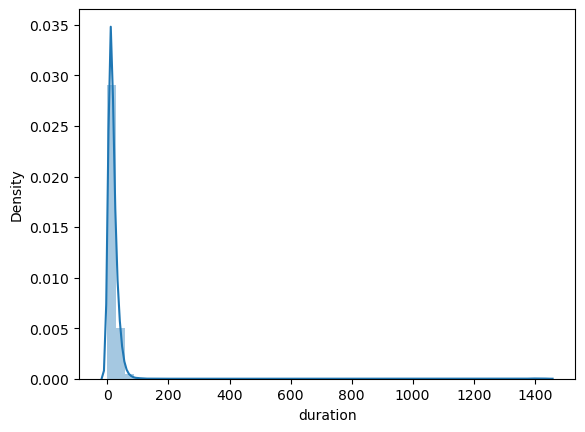

In [9]:
sns.distplot(df.duration)

In [10]:
df.duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [11]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [12]:
((df.duration >= 1) & (df.duration <= 60)).mean()

0.9658903787344154

In [13]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [14]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]


df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [15]:
df[categorical] = df[categorical].astype(str)

In [16]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [17]:
df[categorical + numerical].columns

Index(['PULocationID', 'DOLocationID', 'trip_distance'], dtype='object')

In [18]:
df[categorical + numerical].iloc[:10].to_dict(orient="records")

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48}]

In [19]:
train_dicts = df[categorical + numerical].to_dict(orient="records")
train_dicts[:5]

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45}]

In [20]:
# convert categorcial to vectorizer

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_train[:5]

<5x507 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [21]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [22]:
target = "duration"
df[target][:5], df[target].values[
    :5
]  # The .values attribute of a Series object converts its data into a NumPy array.

(0    3.933333
 1    8.750000
 2    5.966667
 3    7.083333
 7    2.316667
 Name: duration, dtype: float64,
 array([3.93333333, 8.75      , 5.96666667, 7.08333333, 2.31666667]))

In [23]:
y_train = df[target].values
y_train[:5]

array([3.93333333, 8.75      , 5.96666667, 7.08333333, 2.31666667])

/tmp/ipykernel_260273/2686840088.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label="prediction")
/tmp/ipykernel_260273/2686840088.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label="prediction")


<Axes: ylabel='Density'>

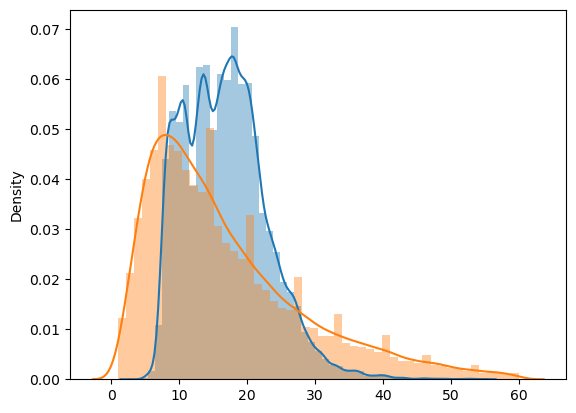

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

sns.distplot(y_pred, label="prediction")
sns.distplot(y_train, label="prediction")

In [25]:
# values dists seeem different

### Automating


In [26]:
def read_dataframe(filename):
    if filename.endswith(".csv"):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith(".parquet"):
        df = pd.read_parquet(filename)

    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)

    return df

In [27]:
df_train = read_dataframe("./data/green_tripdata_2021-01.parquet")
df_val = read_dataframe("./data/green_tripdata_2021-07.parquet")

In [28]:
len(df_train), len(df_val)

(73908, 79097)

In [29]:
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]

In [30]:
categorical = ["PU_DO"]  #'PULocationID', 'DOLocationID']
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [31]:
target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)


mean_squared_error(y_val, y_pred, squared=False)

8.257919100867944

In [33]:
import pickle

with open("./models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)  # savinf dv and model lr

## Using lasso regression


In [34]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

9.853643678604621

In [35]:
df = df[df.trip_type == 2.0]
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
30,2,2021-01-01 00:35:29,2021-01-01 00:55:15,N,5.0,74,247,1.0,3.64,13.0,...,0.0,0.0,0.0,None,0.3,13.3,2.0,2.0,0.0,19.766667
53,2,2021-01-01 01:54:51,2021-01-01 02:15:35,N,5.0,74,94,1.0,5.82,18.0,...,0.0,0.0,0.0,None,0.3,18.3,2.0,2.0,0.0,20.733333
69,2,2021-01-01 02:42:49,2021-01-01 02:50:59,N,5.0,136,241,1.0,0.57,9.0,...,0.0,0.0,0.0,None,0.3,9.3,2.0,2.0,0.0,8.166667
88,2,2021-01-01 04:52:02,2021-01-01 05:05:01,N,5.0,247,75,1.0,3.43,15.0,...,0.0,0.0,0.0,None,0.3,15.3,2.0,2.0,0.0,12.983333
96,2,2021-01-01 05:52:43,2021-01-01 05:58:02,N,5.0,7,7,1.0,0.65,50.0,...,0.0,7.0,0.0,None,0.3,57.3,1.0,2.0,0.0,5.316667
